In [1]:
!pip install transformers datasets evaluate torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train subset size: 5000
Validation size: 872


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer


dataset = load_dataset("glue", "sst2")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(batch):
    return tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


train_subset = dataset["train"].select(range(5000))
val_dataset = dataset["validation"]

In [4]:
import random

def add_label_noise(ds_train, noise_rate=0.1, seed=42):


    ds = ds_train.with_format("numpy")

    n = len(ds)
    num_noisy = int(noise_rate * n)


    noisy_idxs = set(random.Random(seed).sample(range(n), num_noisy))


    labels = [int(l) for l in ds["labels"]]
    for i in noisy_idxs:
        labels[i] = 1 - labels[i]  # flip: 0->1 or 1->0


    ds = ds.remove_columns("labels").add_column("labels", labels)


    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


train_noisy = add_label_noise(train_subset, noise_rate=0.1)




Original label sample: tensor(0)
Noisy label sample: tensor(0)


In [6]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_eval_manual(train_dataset, val_dataset, epochs=2, lr=5e-5, batch_size=16):

    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    ).to(device)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)


    optimizer = AdamW(model.parameters(), lr=lr)


    criterion = torch.nn.CrossEntropyLoss()


    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

    return model, accuracy


model_baseline, acc_baseline = train_eval_manual(train_subset, val_dataset, epochs=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Loss: 0.3707
Epoch 2/2 - Loss: 0.1464
Validation Accuracy: 0.8716


In [7]:
train_noisy_10 = add_label_noise(train_subset, noise_rate=0.1, seed=1)
model_noisy_10, acc_noisy_10 = train_eval_manual(train_noisy_10, val_dataset, epochs=2)


print(f"Baseline (clean labels) Accuracy: {acc_baseline:.4f}")
print(f"10% Noisy Labels Accuracy:        {acc_noisy_10:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Loss: 0.5284
Epoch 2/2 - Loss: 0.3778
Validation Accuracy: 0.8647
---- Results ----
Baseline (clean labels) Accuracy: 0.8716
10% Noisy Labels Accuracy:        0.8647


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2 - Loss: 0.6095
Epoch 2/2 - Loss: 0.4867
Validation Accuracy: 0.7523
---- Final Results ----
Baseline (clean labels) Accuracy: 0.8716
10% Noisy Labels Accuracy:        0.8647
20% Noisy Labels Accuracy:        0.7523


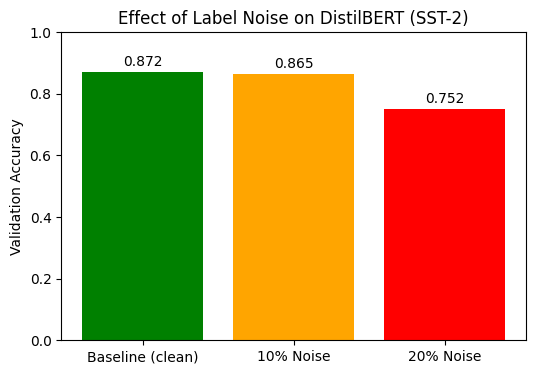

In [8]:

train_noisy_20 = add_label_noise(train_subset, noise_rate=0.2, seed=2)


model_noisy_20, acc_noisy_20 = train_eval_manual(train_noisy_20, val_dataset, epochs=2)



print(f"Baseline (clean labels) Accuracy: {acc_baseline:.4f}")
print(f"10% Noisy Labels Accuracy:        {acc_noisy_10:.4f}")
print(f"20% Noisy Labels Accuracy:        {acc_noisy_20:.4f}")


import matplotlib.pyplot as plt

labels = ["Baseline (clean)", "10% Noise", "20% Noise"]
values = [acc_baseline, acc_noisy_10, acc_noisy_20]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=["green", "orange", "red"])
plt.ylim(0, 1)
plt.ylabel("Validation Accuracy")
plt.title("Effect of Label Noise on DistilBERT (SST-2)")


for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.3f}",
             ha="center", va="bottom", fontsize=10)




In [10]:
plt.show()
plt.savefig("results.png", dpi=150)

<Figure size 640x480 with 0 Axes>